In [1]:

import cv2,os

data_path='data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [2]:
img_size, img_size = 100,100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            target.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed he

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],100,100,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [4]:

np.save('data',data)
np.save('target',new_target)

In [5]:

data=np.load('data.npy')
target=np.load('target.npy')

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1,random_state = 32)


In [10]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/20
990/990 [==============================] - 54s 54ms/step - loss: 0.6842 - accuracy: 0.5364 - val_loss: 0.7392 - val_accuracy: 0.5444
Epoch 2/20
990/990 [==============================] - 55s 56ms/step - loss: 0.5743 - accuracy: 0.6990 - val_loss: 0.4038 - val_accuracy: 0.8306
Epoch 3/20
990/990 [==============================] - 56s 57ms/step - loss: 0.4227 - accuracy: 0.8101 - val_loss: 0.3930 - val_accuracy: 0.8629
Epoch 4/20
990/990 [==============================] - 53s 53ms/step - loss: 0.3011 - accuracy: 0.8717 - val_loss: 0.2598 - val_accuracy: 0.8669
Epoch 5/20
990/990 [==============================] - 54s 54ms/step - loss: 0.2419 - accuracy: 0.9071 - val_loss: 0.2003 - val_accuracy: 0.9194
Epoch 6/20
990/990 [==============================] - 54s 55ms/step - loss: 0.1864 - accuracy: 0.9273 - val_loss: 0.1909 - val_accuracy: 0.9194
Epoch 7/20
990/990 [==============================] - 89s 90ms/step - loss: 0.1293 - accur


Bad key "text.kerning_factor" on line 4 in
C:\Users\D Pranay kumar naidu\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


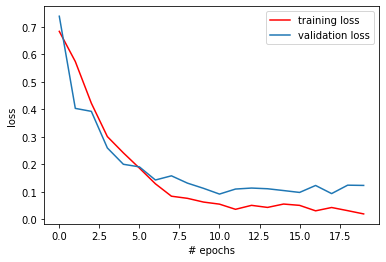

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


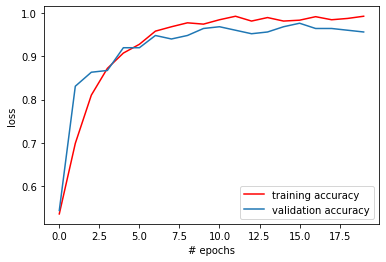

In [12]:

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [2]:
from keras.models import load_model
import cv2
import numpy as np

Using TensorFlow backend.


In [3]:
model = load_model('model-019.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'no MASK',1:'MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}


In [ ]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,1)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
        
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
model = load_model('model-017.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img=cv2.imread('without.jpg')

labels_dict={0:'no MASK',1:'MASK'}
color_dict={0:(0,0,255),1:(0,255,0)}

gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces=face_clsfr.detectMultiScale(gray,1.3,1)

for (x,y,w,h) in faces:
    face_img=gray[y:y+w,x:x+w]
    
    resized=cv2.resize(face_img,(100,100))
    normalized=resized/255.0
    reshaped=np.reshape(normalized,(1,100,100,1))
    result=model.predict(reshaped)
    
    label=np.argmax(result,axis=1)[0]
 
      
    cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
    cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        

cv2.imshow('Result',img)
    
cv2.waitKey(0)

 
cv2.destroyAllWindows()  
        



